[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/sk-classroom/asc-transformers/blob/main/assignments/assignment_01.ipynb)

In this notebook, we will be creating a seq2seq model for machine translation. 
References: 
- [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

# Preparation

In [1]:
# If you are using Google Colab or local environments, install the following packages:
# !pip install bpemb


# Data

The seq2seq will be trained on bilingual sentence pairs taken from [ManyThings.org](https://www.manythings.org/anki/). The dataset contains sentence pairs in the format of "source language sentence" and "target language sentence". 



In [2]:
import pandas as pd
import numpy as np

url = "https://www.manythings.org/anki/fra-eng.zip"

root = ".."
#root = "https://raw.githubusercontent.com/sk-classroom/asc-tranformers/main"

train_data = pd.read_csv(f"{root}/data/fra.txt", sep = "\t", header = None, names = ["source", "target"], usecols=[0,1])
train_data = train_data.head(10000)
train_data


,source,target
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !
...,...,...
9995,We've made it.,Nous avons réussi.
9996,We've made it.,Nous y sommes parvenus.
9997,We've matured.,Nous avons mûri.
9998,We've no time.,Nous n'avons pas le temps.


Additionally, we will use pre-trained word embedding from [BPEMB](https://github.com/bheinzerling/bpemb) to represent the phrases into vectors. 



In [3]:
from bpemb import BPEmb

en_bpemb = BPEmb(lang="en", vs=1000)
fr_bpemb = BPEmb(lang="fr", vs=1000)


In [4]:
text = "Hi, my name is John"

en_tokens = en_bpemb.encode(text)

print("Tokenized by English tokenizer:", en_tokens, " (total =", len(en_tokens), " tokens)")

fr_tokens = fr_bpemb.encode(text)
print("Tokenized by French tokenizer:", fr_tokens, " (total =", len(fr_tokens), " tokens)")

# Generate the sequence of token embeddings
# Passing the tokens through en_bpemb.emb generate the token embeddings
print("English token vectors (print only the first 5 dimensions):\n", en_bpemb.emb[en_tokens][:, :5])


Tokenized by English tokenizer: ['▁h', 'i', ',', '▁m', 'y', '▁name', '▁is', '▁john']  (total = 8  tokens)
Tokenized by French tokenizer: ['▁h', 'i', ',', '▁m', 'y', '▁n', 'a', 'me', '▁', 'is', '▁jo', 'hn']  (total = 12  tokens)
English token vectors (print only the first 5 dimensions):
 [[ 1.12179e-01 -4.30870e-02  1.14996e-01  2.64587e-01  3.01172e-01]
 [-2.38435e-01  5.12301e-01  3.68039e-01  9.17290e-02  7.29746e-01]
 [ 6.39370e-02  3.46926e-01 -2.20221e-01 -7.27650e-02 -2.92797e-01]
 [ 3.08670e-02  3.71310e-01  5.02850e-02  3.94628e-01  6.34760e-02]
 [-3.44800e-03  2.63790e-02 -8.72300e-03 -1.22588e-01  6.26850e-01]
 [ 3.50000e-05 -5.50390e-02  2.03372e-01  3.82068e-01  2.58657e-01]
 [-1.14224e-01 -4.92930e-02 -2.50380e-01 -4.91210e-02  2.58080e-02]
 [-5.07085e-01 -6.08790e-02 -3.25503e-01 -1.10300e-03 -3.38848e-01]]


# Define a seq2seq model

## Tokenizations

Now, let's make a simple seq2seq model consisting of an encoder and a decoder. To understand how they work, let's consider the following example: 

```
Input: I am a student
Target output: Je suis étudiant
```

In seq2seq, we will insert two special tokens, namely `[SOS]` (Start of Sequence) and `[EOS]` (End of Sequence) to the input and the output sequences to inform the model when to start and stop. For example,  

```
Input: I am a student [EOS]
Target output: [SOS] Je suis étudiant [EOS]
```

** Note: [SOS] is not prepended to the input sequence on purpose, because it does not much contribute to encoding. 

## Padding & Truncation 

We will pack multiple sequences into a single fixed-size tensor of size <`batch_size` x `max_length` x `n_dim`> shown below. 

- `batch_size` is the number of sentences in the batch
- `max_length` is the maximum length of the sentences in the batch
- `n_dim` is the dimension of the subword vectors

To make the sequences have the same length, we will pad or truncate the sequences. Namely,  
**Padding** is the process of adding zeros to the sequences to make them have the same length. 
**Truncation** is the process of removing the tokens from the sequences to make them have the same length. 

One can pad the sequences with zeros in the begining or the end, and the choice does not affect the RNNs in theory. Yet, in practice, it is known that post padding (i.e., padding with zeros at the end) is more effective. (See [Dwarampudi & Reddy, 2019](https://arxiv.org/abs/1903.07288)). 

![image.png](images/padding.jpg)

## Implement the tokenizer 

Let's make our tokenizers.

In [5]:
import numpy as np
from scipy import linalg
import torch

class Tokenizer:

    def __init__(self, bpemb_model, max_length = 100, pre_padding = True):
        self.bpemb_model = bpemb_model
        self.max_length = max_length

        # Get the registered keys and vectors
        kv = bpemb_model.emb
        key2index = kv.key_to_index
        self.vocab = list(key2index.keys())
        self.pre_padding = pre_padding
        self.n_tokens = len(self.vocab)

        # Register the special tokens
        self.vocab +=["[SOS]", "[EOS]"]

        # Extend the vocabulary with the special tokens
        self.sos_token_id = self.n_tokens
        self.eos_token_id = self.n_tokens + 1
        self.n_tokens = self.n_tokens + 2

    def tokenize(self, sentences, append_sos):
        """
        Tokenize the sentences into subword vectors

        Parameters
        ----------
        sentences: list of str
            The list of sentences to be tokenized
        append_sos: bool
            If True, [SOS] token are appended to the sequences.

        Return
        ------
        output_seqs: Tensor of shape <n_sentences x max_length x n_dim>
        """

        n_sents = len(sentences)
        output_token_ids = torch.ones((n_sents, self.max_length), dtype = torch.long) * self.n_tokens

        for i, sent in enumerate(sentences):
            tokens = self.bpemb_model.encode_ids(sent)
            tokens = torch.tensor(tokens, dtype = torch.long)

            # Add the special tokens
            if append_sos:
                tokens = tokens[:np.minimum(self.max_length - 2, len(tokens))]
                tokens = np.concatenate([[self.sos_token_id], tokens, [self.eos_token_id]])
            else:
                tokens = tokens[:np.minimum(self.max_length - 1, len(tokens))]
                tokens = np.concatenate([tokens, [self.eos_token_id]])

            if self.pre_padding:
                output_token_ids[i, :len(tokens)] = torch.tensor(tokens)
            else:
                output_token_ids[i, -len(tokens):] = torch.tensor(tokens)

        return output_token_ids

    def get_eos_token(self, n_sents = 1):
        """
        Get the [EOS] token

        Parameters
        ----------
        n_sents: int
            The number of sentences to be generated

        Return
        ------
        output: Tensor of shape <n_sents x 1>
        """
        return torch.ones((n_sents, 1), dtype = torch.long) * self.eos_token_id

    def get_sos_token(self, n_sents = 1):
        """
        Get the [SOS] token

        Parameters
        ----------
        n_sents: int
            The number of sentences to be generated

        Return
        ------
        output: Tensor of shape <n_sents x 1>
        """
        return torch.ones((n_sents, 1), dtype = torch.long) * self.sos_token_id

src_tokenizer = Tokenizer(en_bpemb, max_length = 30, pre_padding=False)
trg_tokenizer = Tokenizer(fr_bpemb, max_length = 30, pre_padding=True)

subword_token_ids = src_tokenizer.tokenize(["FastText", "SlowText"], append_sos = True)
print("Subword token ids:\n", subword_token_ids)
print("Shape:", subword_token_ids.shape) # <n_sentences x max_length x n_dim>



Subword token ids:
 tensor([[1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002,
         1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1000,
           21,  191,  357,  945,  915, 1001],
        [1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002,
         1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1002, 1000,
          762,   90,  357,  945,  915, 1001]])
Shape: torch.Size([2, 30])


## Implement the seq2seq model 

### Implementation design 

The `seq2seq` model consists of an encoder and a decoder, connected by the hidden states. The encoder takes the input sequence and generates the hidden states. The decoder takes the hidden state of the last token, and generate the output sequence.  

<img src="https://pytorch.org/tutorials/_images/seq2seq.png" width="800">

[Source](https://pytorch.org/tutorials/_images/seq2seq.png)



 While [the original paper uses the LSTM for the encoder and the decoder](https://arxiv.org/abs/1409.3215), let's use another more efficient RNN, [Gated Recurrent Unit (GRU) by Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf). In contrast to LSTM, GRU simplifies the architecture by utilizing only a hidden state, omitting the cell state.

![gru](https://media.licdn.com/dms/image/C5612AQH5Im8XrvLmYQ/article-cover_image-shrink_600_2000/0/1564974698831?e=2147483647&v=beta&t=mVx-N8AfjAS5L-ktV6vmi_5LxR1madQ16yT1fRu__Jk)

### Implementation 

Let's implement the seq2seq model. We will use [torch's implmentation of the GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) for the encoder and the decoder. 



In [6]:
import torch

class Seq2Seq(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        """
        Initializes the Seq2Seq model with given parameters.

        Parameters
        ----------
        input_size : int
            The number of expected features in the input `x`
        hidden_size : int
            The number of features in the hidden state `h`
        output_size : int
            The number of features in the output
        """
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        # TODO: Implement
        # HINT: Use `torch.nn.Embedding` to embed the input and output tokens. Reserve the last token (src_tokenizer.n_tokens, and trg_tokenizer.n_tokens)for padding.
        # HINT: Use the `torch.nn.GRU` for the encoder and the decoder. Use `batch_first = True`.
        # HINT: Define two `torch.nn.Linear` and ReLu to map the hidden state of the decorder to the output
        self.src_emb = torch.nn.Embedding(src_tokenizer.n_tokens+1, input_size, padding_idx = src_tokenizer.n_tokens)
        self.trg_emb = torch.nn.Embedding(trg_tokenizer.n_tokens+1, output_size, padding_idx = trg_tokenizer.n_tokens)
        self.encoder = torch.nn.GRU(input_size, hidden_size, batch_first=True) # batch_first means the input and output tensors are provided as (batch, sequence, feature)
        self.decoder = torch.nn.GRU(input_size, hidden_size, batch_first=True)
        self.lin_out_1 = torch.nn.Linear(hidden_size, hidden_size)
        self.lin_out_2 = torch.nn.Linear(hidden_size, output_size)
        self.non_activation = torch.nn.LeakyReLU()

    def forward(self, inputs):
        """
        Parameters
        -----
        inputs: Tensor of shape <batch_size x sequence_length>

        Return
        ----
        hidden: Tensor of shape <1 x hidden_size>
        """
        batch_size = inputs.shape[0]

        # TODO: Embed the input tokens
        inputs = self.src_emb(inputs) # <batch_size x sequence_length x input_size>

        # TODO: Initiailize the hidden states
        # Hint: See the input for the GRU module: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        hidden_state = torch.zeros(1, batch_size, self.hidden_size, dtype=torch.float32)

        # TODO: Run the encoder
        _, hidden = self.encoder(inputs, hidden_state)
        return hidden

    def decode(self, hidden_states, inputs):
        """

        Parameters
        ----------
        hidden_states: Tensor of shape <batch x hidden_size>
        inputs: Tensor of shape <batch x 1 x input_size>

        Return
        ------
        output: Tensor of shape <batch x output_size>
        """

        inputs = self.trg_emb(inputs)

        # TODO: Implement the decoder
        output, hidden = self.decoder(inputs, hidden_states)

        # TODO: Pass the output through the MLP consisting of two linear layers with one ReLu in betweeen.
        output = self.lin_out_1(output)
        output = self.non_activation(output)
        output = self.lin_out_2(output)

        return output, hidden

dim = 256
hidden_dim = 128
seq2seq = Seq2Seq(input_size = dim, hidden_size = hidden_dim, output_size = dim)

In [7]:
# Example
seq2seq.eval()

test_text = ["FastText", "SlowText"]
in_tokens = src_tokenizer.tokenize(test_text, append_sos = False)
print("Sequense size <n_sentences x max_length>:", in_tokens.shape)

# TODO: Compute the last hidden state of the encoder
hidden = seq2seq(in_tokens)
print("Hidden state size is <1, n_sentences, hidden_size>", hidden.shape)

# The first input to the decoder is the [SOS] token.
# The id for the [SOS] token can be generated by `get_sos_token` API
inputs = trg_tokenizer.get_sos_token(n_sents = 2)
print("[SOS] token id", inputs)

# TODO: Run the decoder and generate one token
output, hidden = seq2seq.decode(hidden, inputs)

print("Size of the hidden state from the decoder: <1, n_sentences, n_dim>:", hidden.shape)
print("Size of the output from the decoder: <n_sentences, 1, n_dim>:", output.shape)

Sequense size <n_sentences x max_length>: torch.Size([2, 30])
Hidden state size is <1, n_sentences, hidden_size> torch.Size([1, 2, 128])
[SOS] token id tensor([[1000],
        [1000]])
Size of the hidden state from the decoder: <1, n_sentences, n_dim>: torch.Size([1, 2, 128])
Size of the output from the decoder: <n_sentences, 1, n_dim>: torch.Size([2, 1, 256])


# Training the seq2seq model

## Loss

While the original seq2seq uses the Cross Entropy Loss, we will use a more efficient negative sampling loss, which works as follows: 
1. We will sample a few $k$ random words (i.e., negative examples) from the vocabulary uniformly at random. 
2. Convert the negative examples (i.e., words) into word embeddings.  
3. Compute the similarity (1) between the output from the decoder and the target word embedding, and (2) beween the negative word embeddings and the true word embedding.
4. Compute the binary cross entropy loss between the similarity values. 

In [8]:
class NegativeSamplingLoss(torch.nn.Module):

    def __init__(self, n_negatives):
        super(NegativeSamplingLoss, self).__init__()
        self.n_negatives = n_negatives
        self.loss = torch.nn.BCEWithLogitsLoss(reduction = "mean")

    def forward(self, input_vecs, target_vecs, seq2seq, mask = None):
        """
        input_vecs: <batch_size>
        target_vecs: <batch_size>
        """
        input_vecs = input_vecs.repeat(1, self.n_negatives, 1)
        target_vecs = target_vecs.repeat(1, self.n_negatives, 1)

        if mask is not None:
            input_vecs = input_vecs[~mask]
            target_vecs = target_vecs[~mask]

        batch_size = input_vecs.shape[0]

        if batch_size < 1:
            return 0
        negative_vecs = seq2seq.trg_emb(torch.randint(0, seq2seq.trg_emb.num_embeddings-1, (batch_size, self.n_negatives)))

        pos = torch.sum(input_vecs * target_vecs, dim = 2).view(-1)
        neg = torch.sum(input_vecs * negative_vecs, dim = 2).view(-1)

        pred = torch.cat([pos, neg])
        target = torch.cat([torch.ones_like(pos), torch.zeros_like(neg)])

        return self.loss(pred, target)

loss = NegativeSamplingLoss(n_negatives = 1)

## Dataset & Data loader


In [9]:
train_data
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, dataframe, source_col="source", target_col="target"):
        """
        Args:
            dataframe (pandas.DataFrame): DataFrame containing the source and target sentences.
            source_col (str): The name of the column containing the source sentences.
            target_col (str): The name of the column containing the target sentences.
        """
        self.dataframe = dataframe
        self.source_col = source_col
        self.target_col = target_col

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        source_sentence = self.dataframe.loc[idx, self.source_col]
        target_sentence = self.dataframe.loc[idx, self.target_col]


        return source_sentence, target_sentence

# Assuming `train_data` is a pandas DataFrame containing the source and target sentences
translation_dataset = TranslationDataset(train_data)

# DataLoader
train_loader = DataLoader(translation_dataset, batch_size=1024, shuffle=True)

Optimizer

In [10]:
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=5e-3)

Train 

In [11]:
from tqdm import tqdm

n_epochs = 1
loss_values = []
seq2seq.train()

pbar = tqdm(total=len(train_loader) * n_epochs)

loss2 = torch.nn.CrossEntropyLoss()

for epoch in range(n_epochs):

    for inputs, targets in train_loader:

        optimizer.zero_grad()

        # TODO: Implement the training loop
        in_tokens = src_tokenizer.tokenize(inputs, append_sos = False)
        out_tokens = trg_tokenizer.tokenize(targets, append_sos = True)

        decoder_hidden = seq2seq(in_tokens)

        loss_value = 0
        for i in range(out_tokens.shape[1]-1):
            decoder_inputs = out_tokens[:, i].unsqueeze(1)
            output, decoder_hidden = seq2seq.decode(decoder_hidden, decoder_inputs)

            target_tokens = out_tokens[:, i+1].unsqueeze(1)
#            scores = output.squeeze(1) @ trg_tokenizer.vectors.T
#
#            target_ids = out_token_ids[:, i+1].to(torch.long)
#            mask = target_ids == -1
#            loss_value+=loss2(scores[~mask], target_ids[~mask])
            target_vecs = seq2seq.trg_emb(target_tokens)
            loss_value+= loss(output, target_tokens, seq2seq)

        #loss_value /= out_tokens.shape[0]
        loss_value.backward()
        optimizer.step()

        loss_value = loss_value.item()

        pbar.update(1)
        pbar.set_description(f"Loss: {loss_value:.5f}")
        loss_values.append(loss_value)

seq2seq.eval()

Loss: 0.06285: 100%|██████████| 10/10 [01:07<00:00,  6.20s/it]  

Seq2Seq(
  (src_emb): Embedding(1003, 256, padding_idx=1002)
  (trg_emb): Embedding(1003, 256, padding_idx=1002)
  (encoder): GRU(256, 128, batch_first=True)
  (decoder): GRU(256, 128, batch_first=True)
  (lin_out_1): Linear(in_features=128, out_features=128, bias=True)
  (lin_out_2): Linear(in_features=128, out_features=256, bias=True)
  (non_activation): LeakyReLU(negative_slope=0.01)
)

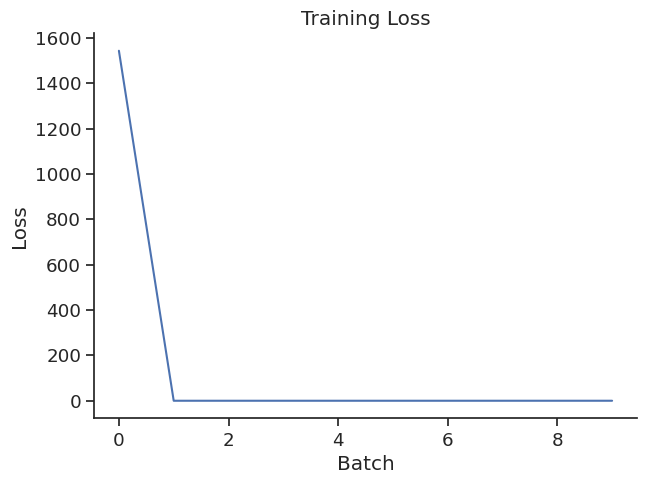

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(loss_values)
ax.set_xlabel("Batch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")
sns.despine()

# Validation

In [16]:
def generate_sequence(sentence, seq2seq, src_tokenizer, trg_tokenizer, max_length, temperature = 0.3):
    in_seqs = src_tokenizer.tokenize([sentence], append_sos = False)
    decoder_hidden = seq2seq(in_seqs)

    decoder_inputs = trg_tokenizer.get_sos_token()
    softmax = torch.nn.Softmax(dim = 1)
    out_seq = []
    for _ in range(max_length):
        output, decoder_hidden = seq2seq.decode(decoder_hidden, decoder_inputs)
        scores = output.squeeze(1) @ seq2seq.trg_emb.weight.T
        prob = softmax(scores / temperature)
        print(scores)
        idx = torch.argmax(prob, dim = 1)
        decoder_inputs = torch.ones((1, 1), dtype = torch.long) * idx

        out_seq.append(trg_tokenizer.vocab[idx])

        if idx == trg_tokenizer.eos_token_id:
            break
    return out_seq

seq2seq.eval()
generate_sequence("Chao.", seq2seq, src_tokenizer, trg_tokenizer, max_length = 30, temperature = 1)



tensor([[ 1.0695,  0.6677, -2.0073,  ..., 12.5573,  3.6371,  0.0000]],
       grad_fn=<MmBackward0>)
tensor([[ 1.6101,  0.0123, -0.8961,  ..., 10.1091,  4.5737,  0.0000]],
       grad_fn=<MmBackward0>)
tensor([[2.2678, 0.4254, 0.1802,  ..., 9.6101, 4.2351, 0.0000]],
       grad_fn=<MmBackward0>)
tensor([[2.8008, 0.4318, 0.5856,  ..., 9.2753, 3.6412, 0.0000]],
       grad_fn=<MmBackward0>)
tensor([[3.2038, 0.3377, 0.7271,  ..., 8.9645, 3.3869, 0.0000]],
       grad_fn=<MmBackward0>)
tensor([[3.4390, 0.2568, 0.6477,  ..., 8.7653, 3.3339, 0.0000]],
       grad_fn=<MmBackward0>)
tensor([[3.5723, 0.2412, 0.5670,  ..., 8.6960, 3.3242, 0.0000]],
       grad_fn=<MmBackward0>)
tensor([[3.6212, 0.2079, 0.5113,  ..., 8.7385, 3.3439, 0.0000]],
       grad_fn=<MmBackward0>)
tensor([[3.6472, 0.1666, 0.4616,  ..., 8.8023, 3.3752, 0.0000]],
       grad_fn=<MmBackward0>)
tensor([[3.6592, 0.1360, 0.4176,  ..., 8.8487, 3.3997, 0.0000]],
       grad_fn=<MmBackward0>)
tensor([[3.6632, 0.1111, 0.3848,  ...,

['man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man',
 'man']